# Objetivos deste trabalho:
- Se familiarizar com o ambiente Notebook e com Python
- Implementar um perceptron simples, treiná-lo no conjunto de TREINO do CIFAR-10 e avaliá-lo no conjunto de TESTE (alvo: distinguir fotos de animais de meios de transporte)
- Utilizar a função sigmóide e verificar seu efeito no treinamento e na avaliação
- Modificar a metodologia para classificar cada classe individualmente (i.e. treinar 10 perceptrons, um para cada classe). Considerar: dado um exemplo, que passará por cada perceptron, como decidir qual é a classe dele?

In [1]:
# imports and config
%matplotlib inline

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# load CIFAR10 datasets

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# CIFAR10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# print length of train and test data
print(len(dataset_train), len(dataset_test))

50000 10000


In [5]:
# convert to shades of grey

# train
grayscale_dataset_train = []
for img,label in dataset_train:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_train.append((gray_npimg,category))
    
# test
grayscale_dataset_test = []
for img,label in dataset_test:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_test.append((gray_npimg,category))    

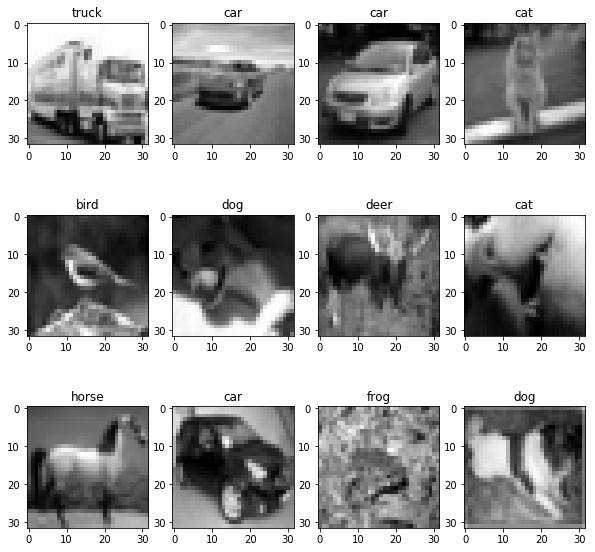

In [6]:
# show a few train images

fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    image_index = random.randint(0, len(dataset_train))
    label = grayscale_dataset_train[image_index][1]
    npimg = grayscale_dataset_train[image_index][0]

    fig.add_subplot(rows, columns, i)
    
    plt.imshow(npimg, cmap='gray')
    plt.title(label)
    
plt.show()

In [7]:
# Converter para vetores 1D

# Para pensar: por que a divisão por 255 no código abaixo?
# Técnica de normalização, serve para evitar weights de magnitudes muito elevadas, 
# visto que é a relação entre eles que prevalece.

# Como os valores dos pixels vão de 0 até 255, dividir eles pelo máximo resulta num valor entre 0 e 1.

linear_dataset_train = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_train:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_train.append((linear_img,label))
    
linear_dataset_test = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_test:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_test.append((linear_img,label))    

In [8]:
size = len(linear_dataset_train[0][0])
print(size)

1024


# Definindo o perceptron
Perceptron foi definido como uma classe, para facilitar interpretação e utilização.

In [9]:
class Perceptron(object):
    
    def __init__(self, neta=0.001):
        self.neta = neta
        self.weights = (np.random.rand(1,size) - 0.5)[0]
        bias = (np.random.rand(1) - 0.5) 
        self.weights = np.append(self.weights, bias) 
        self.accuracies = []
        self.losses = []
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def predict(self, inputs):
        o = np.dot(inputs, self.weights)
        y = self.sigmoid(o)
        return y
    

    def evaluate(self, dataset):
        hits = 0
        for image,label in dataset:
            image = np.append(image, 1)
            # Defina a métrica de avaliação do perceptron aqui (e.g. acurácia)
            y = self.predict(image)

            if(y >= 0.5 and label == 1):
                hits += 1

            elif(y < 0.5 and label == 0):
                hits += 1

        accuracy = hits / len(dataset)
        return accuracy
    
    # balance multiplier is used to reward the perceptron on true positives (for unbalanced datasets)
    def train(self, dataset, epochs=100, verbose="not_verbose", balance_multiplier=1):
        np.random.shuffle(dataset)

        for epoch in range(epochs):
            hits = 0
            loss = 0
            for image, label in dataset:
                image = np.append(image, 1)
                
                y = self.predict(image)
                reward = 1
                
                    
                if label == 1:
                    reward = balance_multiplier
                    
                if(y >= 0.5 and label == 1):
                    hits += 1
                    

                elif(y < 0.5 and label == 0):
                    hits += 1

                delta_weights = self.neta * (label - y) * image * y * (1 - y) * reward
                self.weights += delta_weights
                loss += (label - y)**2

            accuracy = hits / len(linear_dataset_train)
            self.accuracies = np.append(self.accuracies, accuracy)
            self.losses = np.append(self.losses, loss)

            if(verbose == "verbose"):
                print("%5.0f %12f %15f" %(epoch+1, accuracy, loss))
                #print(epoch,"\t", accuracy, "\t", loss)
            
    
    def plotResults(self):
        plt.plot(self.accuracies)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy")
        plt.show()

        plt.plot(self.losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.show()

# Treinando o perceptron

In [10]:
p0 = Perceptron()
p0.train(linear_dataset_train, 100, "verbose")

    1     0.634380    12878.722374
    2     0.685440    11085.542380
    3     0.694380    10712.189359
    4     0.701000    10518.441878
    5     0.703880    10378.347279
    6     0.706800    10266.016246
    7     0.708580    10172.227566
    8     0.710660    10092.280487
    9     0.712040    10023.271433
   10     0.713240     9963.199348
   11     0.714540     9910.583345
   12     0.716140     9864.270654
   13     0.717760     9823.331318
   14     0.718600     9786.997209
   15     0.719440     9754.624668
   16     0.720280     9725.669888
   17     0.720760     9699.671350
   18     0.721400     9676.236343
   19     0.721960     9655.030115
   20     0.722380     9635.766886
   21     0.722920     9618.202293
   22     0.723620     9602.127033
   23     0.724100     9587.361487
   24     0.724600     9573.751190
   25     0.724860     9561.163016
   26     0.725080     9549.481966
   27     0.725220     9538.608458
   28     0.725520     9528.456057
   29     0.725600  

In [11]:
# Avalie o modelo treinado aqui
# Como a acurácia no conjunto de teste se compara com a acurácia obtida no conjunto de treino?

# A acurácia no conjunto de treino é maior devido ao overfitting do conjunto de treinamento.
# Analogamente, a acurácia do conjunto de teste é menor justamente pelo fato de que as imagens do 
# conjunto de teste nunca foram apresentadas ao modelo.

accuracy_train = p0.evaluate(linear_dataset_train)
accuracy_test = p0.evaluate(linear_dataset_test)

print("Train Accuracy: ", accuracy_train, "\tTest Accuracy: ", accuracy_test)


Train Accuracy:  0.73624 	Test Accuracy:  0.7263


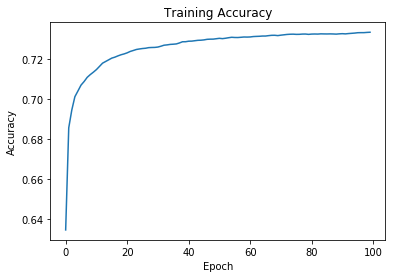

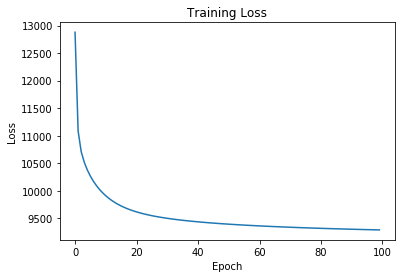

In [12]:
# Caso queiram plotar alguma coisa

p0.plotResults()


# Classificando classes individuais

Implemente aqui a modificação do processo de avaliação e treinamento para poder classificar cada classe individualmente.

- Ideia geral: treinar um perceptron por classe (exemplo positivo = exemplos da classe; exemplos negativos = exemplo de todas outras classes)
- Dado um exemplo qualquer, como decidir qual perceptron está dando a classe correta?

Pode ser decidido simplesmente pelo perceptron do arranjo com a saída maior.

In [13]:
def classes_get(x):
    return {
        0: "plane",
        1: "car",
        2: "bird",
        3: "cat",
        4: "deer",
        5: "dog",
        6: "frog",
        7: "horse",
        8: "ship",
        9: "truck",
    }[x]

In [14]:
# converter para vetores 1D

linear_dataset_array_train = [[] for i in range(10)]
linear_dataset_array_test = [[] for i in range(10)]

for index in range(10):
    
    target_labels = classes_get(index)
    for img,category in grayscale_dataset_train:
        linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
        #linear_img = img
        if category in target_labels:
            label = 1
        else:
            label = 0
        linear_dataset_array_train[index].append((linear_img,label))

    
    
    for img,category in grayscale_dataset_test:
        linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
        #linear_img = img
        if category in target_labels:
            label = 1
        else:
            label = 0
        linear_dataset_array_test[index].append((linear_img,label))
    

In [15]:
# size of train dataset list and train dataset for perceptron 0
print(len(linear_dataset_array_train))
print(len(linear_dataset_array_train[0]))

# size of test dataset list and test dataset for perceptron 0
print(len(linear_dataset_array_test))
print(len(linear_dataset_array_test[0]))

10
50000
10
10000


############################################
Training Perceptron 0
    1     0.494920    16128.609452
    2     0.529800    14619.980533
    3     0.546020    14001.593606
    4     0.559940    13577.324321
    5     0.568900    13267.300728
    6     0.577760    13033.886702
    7     0.584520    12853.870028
    8     0.590240    12711.962162
    9     0.595220    12597.868517
   10     0.598900    12504.519127
   11     0.602640    12426.951175
   12     0.604900    12361.604335
   13     0.607300    12305.873055
   14     0.610100    12257.816654
   15     0.611980    12215.967024
   16     0.613540    12179.197934
   17     0.614940    12146.634252
   18     0.615860    12117.587729
   19     0.617060    12091.510880
   20     0.617940    12067.963440
   21     0.619140    12046.587695
   22     0.619620    12027.090160
   23     0.620560    12009.227831
   24     0.621040    11992.797785
   25     0.621740    11977.629222
   26     0.622140    11963.577332
   27     0.622420    1

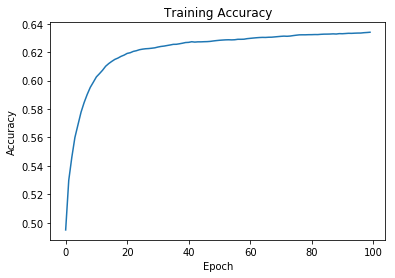

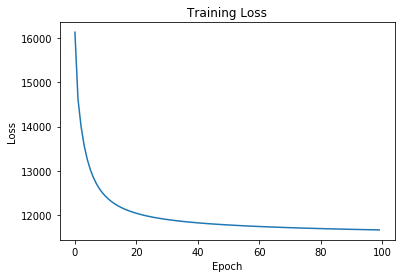




############################################
Training Perceptron 1
    1     0.653560    11872.226201
    2     0.687200    10886.737496
    3     0.693920    10648.879892
    4     0.698140    10489.465287
    5     0.699980    10370.884588
    6     0.703000    10278.778242
    7     0.705480    10205.644256
    8     0.706320    10146.732401
    9     0.708060    10098.691263
   10     0.708900    10059.038262
   11     0.710520    10025.904111
   12     0.711600     9997.874917
   13     0.711720     9973.877919
   14     0.712340     9953.095115
   15     0.712780     9934.898335
   16     0.713140     9918.801132
   17     0.713540     9904.423465
   18     0.714040     9891.465860
   19     0.714000     9879.690435
   20     0.714480     9868.906862
   21     0.714680     9858.961861
   22     0.715100     9849.731260
   23     0.715440     9841.113914
   24     0.715780     9833.027013
   25     0.716060     9825.402415
   26     0.716200     9818.183770
   27     0.716440  

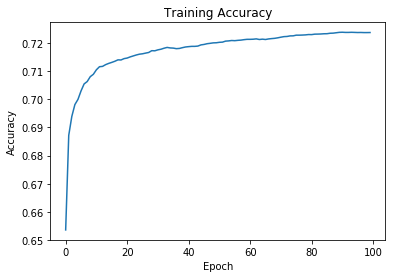

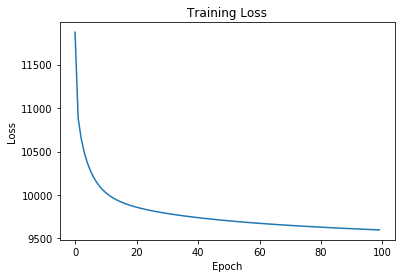




############################################
Training Perceptron 2
    1     0.503860    15999.597978
    2     0.530620    14653.146302
    3     0.535320    14248.166202
    4     0.538560    14014.398089
    5     0.540220    13867.539660
    6     0.540760    13769.760862
    7     0.541420    13700.716382
    8     0.542160    13648.879055
    9     0.541620    13607.614354
   10     0.542760    13573.073077
   11     0.543980    13543.002297
   12     0.543980    13516.068417
   13     0.545080    13491.469921
   14     0.545660    13468.714570
   15     0.546280    13447.490550
   16     0.547200    13427.591700
   17     0.547760    13408.874042
   18     0.548360    13391.230531
   19     0.549320    13374.576392
   20     0.549360    13358.840638
   21     0.549500    13343.961176
   22     0.550020    13329.882008
   23     0.550440    13316.551627
   24     0.550820    13303.922104
   25     0.551080    13291.948570
   26     0.551300    13280.588911
   27     0.551820  

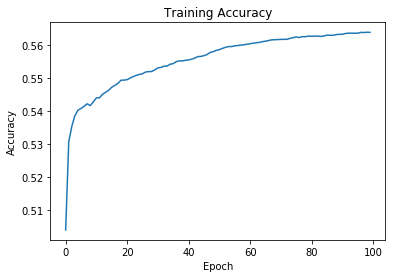

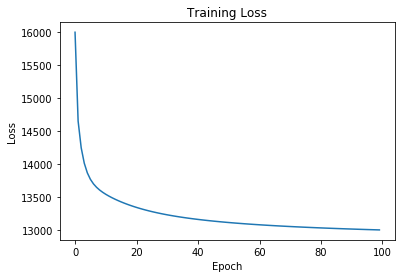




############################################
Training Perceptron 3
    1     0.512720    15939.054851
    2     0.547940    14218.177025
    3     0.551420    13840.982919
    4     0.552380    13635.267824
    5     0.553260    13506.900411
    6     0.553500    13419.434871
    7     0.553960    13355.315007
    8     0.554180    13305.155025
    9     0.553540    13263.690786
   10     0.554380    13227.871694
   11     0.554820    13195.885298
   12     0.555680    13166.635264
   13     0.555960    13139.450192
   14     0.555780    13113.914867
   15     0.555740    13089.769423
   16     0.555680    13066.847896
   17     0.556160    13045.040472
   18     0.556420    13024.270311
   19     0.556360    13004.479471
   20     0.557080    12985.620494
   21     0.557240    12967.651509
   22     0.558120    12950.533495
   23     0.558680    12934.228853
   24     0.559420    12918.700737
   25     0.559720    12903.912826
   26     0.559840    12889.829332
   27     0.560080  

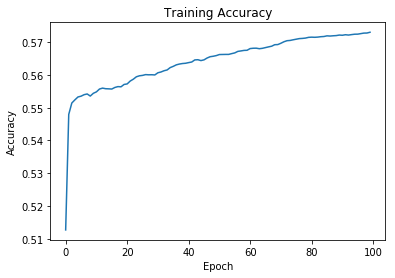

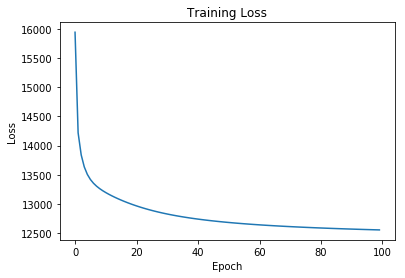




############################################
Training Perceptron 4
    1     0.512200    16342.214500
    2     0.543320    14550.158727
    3     0.550240    14061.355359
    4     0.552860    13798.881289
    5     0.555660    13635.756774
    6     0.558060    13523.076762
    7     0.559680    13439.475806
    8     0.560660    13374.372224
    9     0.561220    13321.826021
   10     0.561640    13278.161119
   11     0.562600    13240.961199
   12     0.563300    13208.584290
   13     0.563740    13179.892563
   14     0.565020    13154.085941
   15     0.564820    13130.593905
   16     0.565160    13109.003339
   17     0.565360    13089.009900
   18     0.565300    13070.385021
   19     0.565360    13052.953445
   20     0.565520    13036.577831
   21     0.566240    13021.148166
   22     0.566740    13006.574408
   23     0.567200    12992.781363
   24     0.567340    12979.705063
   25     0.567680    12967.290188
   26     0.567920    12955.488221
   27     0.568160  

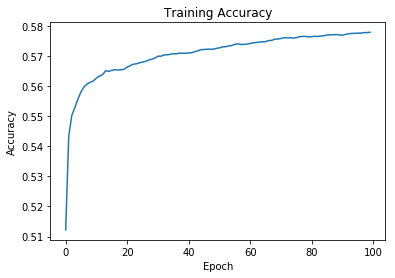

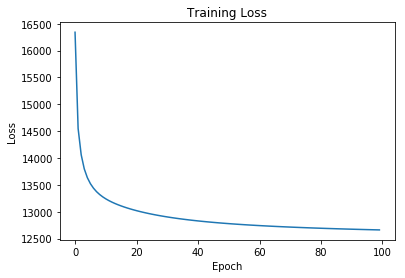




############################################
Training Perceptron 5
    1     0.545340    15537.100333
    2     0.576060    13545.418320
    3     0.581180    13175.392530
    4     0.584140    12941.214238
    5     0.587300    12773.459230
    6     0.590380    12645.302241
    7     0.593040    12542.935150
    8     0.594860    12458.833589
    9     0.595720    12388.441207
   10     0.597400    12328.693932
   11     0.599080    12277.384275
   12     0.600240    12232.860533
   13     0.601200    12193.860752
   14     0.601900    12159.407517
   15     0.602920    12128.735407
   16     0.603660    12101.238847
   17     0.604160    12076.433912
   18     0.605240    12053.930077
   19     0.605640    12033.409179
   20     0.605940    12014.609620
   21     0.606520    11997.314444
   22     0.606640    11981.342239
   23     0.607020    11966.540157
   24     0.607300    11952.778499
   25     0.607700    11939.946486
   26     0.608040    11927.948918
   27     0.608400  

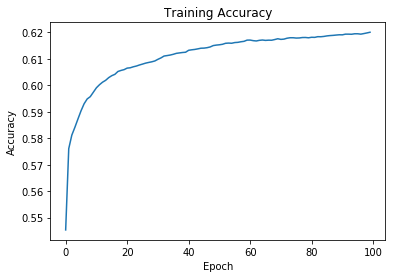

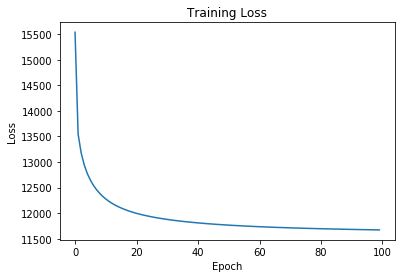




############################################
Training Perceptron 6
    1     0.516600    16290.874397
    2     0.560120    14252.040859
    3     0.569600    13812.683040
    4     0.572820    13539.502419
    5     0.574880    13354.009630
    6     0.577360    13225.464884
    7     0.577660    13134.905419
    8     0.577900    13069.398933
    9     0.578700    13020.264968
   10     0.580180    12981.870914
   11     0.581120    12950.634360
   12     0.581840    12924.285943
   13     0.582840    12901.377029
   14     0.582960    12880.968949
   15     0.583820    12862.441729
   16     0.584700    12845.377069
   17     0.585020    12829.486369
   18     0.585480    12814.565914
   19     0.586160    12800.468557
   20     0.586460    12787.085498
   21     0.587100    12774.334373
   22     0.587800    12762.151323
   23     0.588120    12750.485637
   24     0.588680    12739.296084
   25     0.589260    12728.548361
   26     0.589620    12718.213303
   27     0.589920  

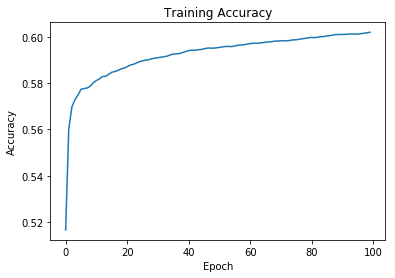

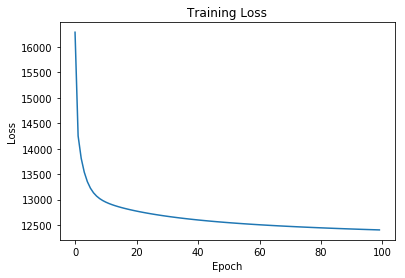




############################################
Training Perceptron 7
    1     0.554120    14993.874995
    2     0.580120    13460.716451
    3     0.585860    13101.625146
    4     0.589320    12877.743848
    5     0.591920    12721.983727
    6     0.593780    12608.314301
    7     0.594540    12522.444564
    8     0.595340    12455.638917
    9     0.596000    12402.233036
   10     0.596660    12358.427363
   11     0.597100    12321.623819
   12     0.596720    12290.024547
   13     0.598340    12262.373849
   14     0.598880    12237.786442
   15     0.599640    12215.631254
   16     0.600260    12195.452276
   17     0.600700    12176.914583
   18     0.601460    12159.767502
   19     0.601660    12143.819466
   20     0.602400    12128.920827
   21     0.602820    12114.952063
   22     0.603100    12101.815646
   23     0.603320    12089.430396
   24     0.604020    12077.727529
   25     0.603980    12066.647855
   26     0.604740    12056.139773
   27     0.604860  

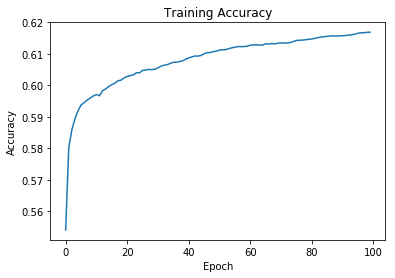

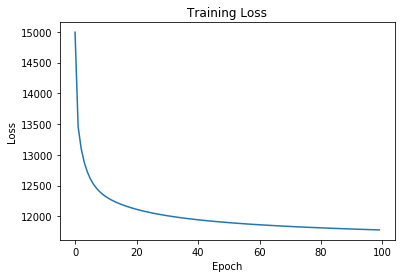




############################################
Training Perceptron 8
    1     0.614140    13911.473921
    2     0.628460    12884.498863
    3     0.636360    12404.488341
    4     0.641840    12097.771396
    5     0.646840    11867.241300
    6     0.651920    11684.726917
    7     0.656580    11536.732656
    8     0.659800    11415.111119
    9     0.663080    11314.242678
   10     0.665260    11229.941129
   11     0.667780    11158.965568
   12     0.669020    11098.762487
   13     0.670280    11047.305225
   14     0.672200    11002.980717
   15     0.673320    10964.503252
   16     0.674500    10930.846444
   17     0.675220    10901.189012
   18     0.676380    10874.871638
   19     0.677180    10851.362830
   20     0.677900    10830.232045
   21     0.679440    10811.128610
   22     0.680000    10793.765227
   23     0.680380    10777.905072
   24     0.680740    10763.351691
   25     0.681100    10749.941081
   26     0.682020    10737.535462
   27     0.682580  

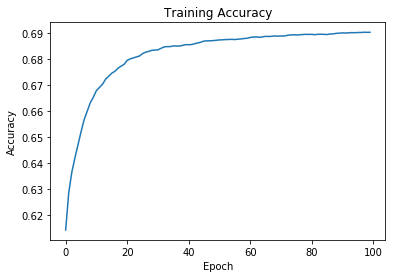

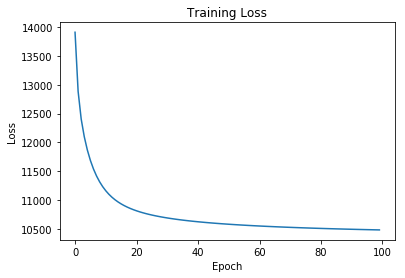




############################################
Training Perceptron 9
    1     0.648220    12842.034416
    2     0.709700    10347.500738
    3     0.720500    10013.565924
    4     0.725480     9838.481644
    5     0.728080     9730.244911
    6     0.729980     9652.344027
    7     0.731440     9590.174552
    8     0.732660     9537.720749
    9     0.734360     9492.103372
   10     0.735560     9451.676968
   11     0.736180     9415.375888
   12     0.736840     9382.461727
   13     0.737560     9352.404330
   14     0.737800     9324.812911
   15     0.738740     9299.390235
   16     0.739420     9275.900950
   17     0.739620     9254.150547
   18     0.739880     9233.972369
   19     0.740240     9215.220071
   20     0.740580     9197.763336
   21     0.741240     9181.485322
   22     0.741720     9166.280944
   23     0.742000     9152.055572
   24     0.742540     9138.723941
   25     0.742960     9126.209185
   26     0.743380     9114.441977
   27     0.744220  

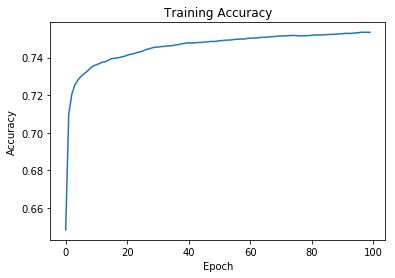

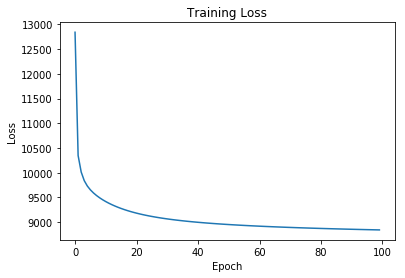

In [16]:
# initializing all 10 perceptrons
perceptrons = [Perceptron(0.001) for i in range(10)]
index = 0

# training all perceptrons
for p in perceptrons:
    print("############################################")
    print("Training Perceptron", index)

    # each perceptron uses its own datasets
    p.train(linear_dataset_array_train[index], 100, "verbose", 10)

    # evaluating each individual perceptron with train and test datasets(only once)
    # notice the overfit difference with the training evaluation
    accuracy_train = p.evaluate(linear_dataset_array_train[index])
    accuracy_test = p.evaluate(linear_dataset_array_test[index])

    print("\nTrain Accuracy: ", accuracy_train, "\tTest Accuracy: ", accuracy_test, "\n")

    p.plotResults()

    print("\n\n")
    index += 1


In [17]:
# creating dataset with numbered class labels
linear_dataset_test_labels = []

for img,category in grayscale_dataset_test:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    label = classes.index(category)
    linear_dataset_test_labels.append((linear_img,label))


In [20]:
# evaluating final model with test dataset

hits = 0
most_active_perceptron = 0

y_true = []
y_pred = []
    
for image,label in linear_dataset_test_labels:
    y_true.append(label)
    
    image = np.append(image, 1)
    index = 0
    max_output = 0
    
    for p in perceptrons:
        result = p.predict(image)
        if result > max_output:
            
            max_output = result
            most_active_perceptron = index
            
        index += 1
    
    y_pred.append(most_active_perceptron)
    if label == most_active_perceptron:
        hits += 1
    
accuracy = hits / len(linear_dataset_test_labels)

print(accuracy)

cm = confusion_matrix(y_true, y_pred)

0.2551


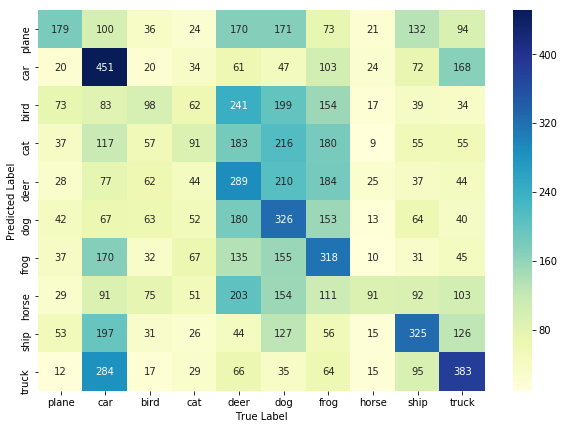

In [21]:
# plotting confusion matrix

df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.YlGnBu, fmt='d')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

# Considerações Finais
- Arranjo final possui desempenho dentro do esperado.
- Foi necessário tratar true positives com mais significância nos datasets desbalanceados.